In [256]:
from CoolProp.CoolProp import PropsSI
import numpy as np
import matplotlib.pyplot as plt

In [257]:
class Solid_TES:
    def __init__(self, Tfin:float = 300.0, Pfin:float = 20.0, mdot:float = 20.0, fluid: str = 'air', Tinit = 600, tend: float = 5.0):
        
        self.fluid = fluid
        self.Tfin = Tfin+273.15
        self.Pfin = Pfin*1.0e5
        self.mdot = mdot
        self.Tinit = Tinit+273.15
        self.tend = tend*3600
        self.Pcrit = PropsSI('PCRIT','',0,'',0,self.fluid)
        #self.Tarray = np.ones((self.Ntime, self.Naxis, self.Nrad))*Tinit
    
    def set_matrix(self):
        self.tarray = np.array([0])
        t = -1
        while 1:
            t = t+1
            for l in np.arange(len(self.Lpos)):
                if l == 0:
                    if self.Pcrit > self.Pfin:
                        hgin = PropsSI('H','P',self.Pfin,'Q',1.0,self.fluid)
                        hlin = PropsSI('H','P',self.Pfin,'Q',0.0,self.fluid)
                        hfin = PropsSI('H','T',self.Tfin,'P',self.Pfin,self.fluid)
                        xfin = (hfin - hlin)/(hgin - hlin)
                    else:
                        hfin = PropsSI('H','T',self.Tfin,'P',self.Pfin,self.fluid)
                        xfin = 1.0
                        
                    (h,f, rho) = self.calc_correlation(self.Tfin, self.Pfin, xfin, self.mdot)
                    self.Pfarray[l] = self.Pfin - f/2/rho*self.G**2
                    self.hfarray[l] = hfin+h*self.dL[l]*2*np.pi*self.Rpipe*self.pipe_mult*self.area_mult*(self.Tarray[t,0,l]-self.Tfin)/self.mdot
                    self.Tfarray[t, l] = PropsSI('T','H',self.hfarray[l],'P',self.Pfarray[l],self.fluid)
                    self.dtarray[l] = self.dL[l]/(self.G/rho)
                else:
                    if self.Pcrit > self.Pfarray[l-1]:
                        hgin = PropsSI('H','P',self.Pfarray[l-1],'Q',1.0,self.fluid)
                        hlin = PropsSI('H','P',self.Pfarray[l-1],'Q',0.0,self.fluid)
                        xfin = (self.hfarray[l-1] - hlin)/(hgin - hlin)
                    else:
                        xfin = 1.0
                    
                    (h,f, rho) = self.calc_correlation(self.Tfarray[t,l-1], self.Pfarray[l-1], xfin, self.mdot)
                    self.Pfarray[l] = self.Pfarray[l-1] - f/2/rho*self.G**2
                    self.hfarray[l] = self.hfarray[l-1]+h*self.dL[l]*2*np.pi*self.Rpipe*self.pipe_mult*self.area_mult*(self.Tarray[t,0,l]-self.Tfarray[t,l-1])/self.mdot
                    self.Tfarray[t, l] = PropsSI('T','H',self.hfarray[l],'P',self.Pfarray[l],self.fluid)
                    self.dtarray[l] = self.dL[l]/(self.G/rho)
            
            self.dtime = min(self.dtarray)
            self.tarray = np.append(self.tarray, self.tarray[-1]+self.dtime, axis=0)
            
            Tcurrent = np.empty((self.Nrad_pipe+self.Nrad_sand,0))
            for l in np.arange(len(self.Lpos)):
                
                for r in np.arange(len(self.rpos)):
                    if r == 0:
                        (Cp, rho, k) = self.call_mixture_property('sus', 'sus', 0.0, (self.Tarray[t,r,l]+self.Tarray[t,r+1,l])*0.5)
                        self.Amat[r,r] = -(k/(self.rpos[r+1]-self.rpos[r])+h)
                        self.Amat[r,r+1] = k/(self.rpos[r+1]-self.rpos[r])
                        self.S[r] = -h*self.Tfarray[t,l]
                    elif r == len(self.rpos)-1:
                        self.Amat[r,r-1] = 1
                        self.Amat[r,r] = -1
                        self.S[r] = 0
                    else:
                        if l < self.Naxis_sand:
                            if r < self.Nrad_pipe-1:
                                (Cp1, rho1, k1) = self.call_mixture_property('sus', 'sus', 0.0, (self.Tarray[t,r,l]+self.Tarray[t,r-1,l])*0.5)
                                (Cp2, rho2, k2) = self.call_mixture_property('sus', 'sus', 0.0, (self.Tarray[t,r,l]+self.Tarray[t,r+1,l])*0.5)
                            elif r == self.Nrad_pipe-1:
                                (Cp1, rho1, k1) = self.call_mixture_property('sus', 'sus', 0.0, (self.Tarray[t,r,l]+self.Tarray[t,r-1,l])*0.5)    
                                (Cp2, rho2, k2) = self.call_mixture_property('sand', 'air', self.porosity, (self.Tarray[t,r,l]+self.Tarray[t,r+1,l])*0.5)
                            else:
                                (Cp1, rho1, k1) = self.call_mixture_property('sand', 'air', self.porosity, (self.Tarray[t,r,l]+self.Tarray[t,r-1,l])*0.5)
                                (Cp2, rho2, k2) = self.call_mixture_property('sand', 'air', self.porosity, (self.Tarray[t,r,l]+self.Tarray[t,r+1,l])*0.5)
                        else:
                            if r < self.Nrad_pipe-1:
                                (Cp1, rho1, k1) = self.call_mixture_property('sus', 'sus', 0.0, (self.Tarray[t,r,l]+self.Tarray[t,r-1,l])*0.5)
                                (Cp2, rho2, k2) = self.call_mixture_property('sus', 'sus', 0.0, (self.Tarray[t,r,l]+self.Tarray[t,r+1,l])*0.5)
                            if r == self.Nrad_pipe-1:
                                (Cp1, rho1, k1) = self.call_mixture_property('sus', 'sus', 0.0, (self.Tarray[t,r,l]+self.Tarray[t,r-1,l])*0.5)    
                                (Cp2, rho2, k2) = self.call_mixture_property('sand', 'al', self.sand_al_ratio, (self.Tarray[t,r,l]+self.Tarray[t,r+1,l])*0.5)
                            else:
                                (Cp1, rho1, k1) = self.call_mixture_property('sand', 'al', self.sand_al_ratio, (self.Tarray[t,r,l]+self.Tarray[t,r-1,l])*0.5)
                                (Cp2, rho2, k2) = self.call_mixture_property('sand', 'al', self.sand_al_ratio, (self.Tarray[t,r,l]+self.Tarray[t,r+1,l])*0.5)
                            
                        theta = 0.5 # Crank-Nicholson 
                        xi1 = (self.rpos[r-1]+self.rpos[r])*0.5
                        xi2 = (self.rpos[r]+self.rpos[r+1])*0.5
                        dV1 = 0.5*(self.rpos[r]**2-xi1**2)
                        dV2 = 0.5*(xi2**2-self.rpos[r]**2)
                        
                        a = -theta*k1*xi1/(self.rpos[r]-self.rpos[r-1])
                        c = -theta*k2*xi2/(self.rpos[r+1]-self.rpos[r])
                        b = (rho1*Cp1*dV1+rho2*Cp2*dV2)/self.dtime-a-c
                        d = (rho1*Cp1*dV1+rho2*Cp2*dV2)/self.dtime*self.Tarray[t,r,l]+(1-theta)/theta*(-a*self.Tarray[t,r-1,l]+(a+c)*self.Tarray[t,r,l]-c*self.Tarray[t,r+1,l])
                        
                        self.Amat[r,r-1] = a
                        self.Amat[r,r] = b
                        self.Amat[r,r+1] = c
                        self.S[r] = d
                
                Tcurrent = np.append(Tcurrent, np.dot(np.linalg.inv(self.Amat),self.S).reshape(self.Nrad_pipe+self.Nrad_sand, 1), axis=1)            
            
            self.Tarray = np.append(self.Tarray, Tcurrent.reshape(1,self.Nrad_pipe+self.Nrad_sand,self.Naxis_sand+self.Naxis_pcm), axis =0)
            self.Tfarray = np.append(self.Tfarray, self.Tfarray[-1,:].reshape(-1,self.Naxis_sand+self.Naxis_pcm), axis=0)
            
                            
            if self.tarray[-1] > self.tend:
                break
            else:
                print(self.tarray[-1])
                print(self.dtime)
    
    def set_geometry(self, Rmodule=0.5, Lmodule=10.0, Rpipe = 0.05, tpipe = 0.01, pipe_mult = 1.0, area_mult = 1.0, pcm_ratio = 0.0, porosity = 0.4, sand_al_ratio = 0.4, Nrad=20, Naxis=30):
        
        
        Lsand = Lmodule*(1-pcm_ratio)
        Lpcm = Lmodule*pcm_ratio
        Nrad_pipe = max(Nrad*round(Rpipe/Rmodule),3)
        Nrad_sand = Nrad - Nrad_pipe
        
        drpipe = tpipe/(Nrad_pipe -1)
        drsand = (Rmodule-tpipe-Rpipe)/(Nrad_sand)
        
        if pcm_ratio == 0.0:
            Naxis_pcm = 0
            dLpcm = 0
        else:
            Naxis_pcm = max(Naxis*round(pcm_ratio),3)
            dLpcm = Lpcm/(Naxis_pcm)
        
        Naxis_sand = Naxis - Naxis_pcm
        dLsand = Lsand/(Naxis_sand-1)
        
        
        self.rpos =[Rpipe+i*drpipe for i in np.arange(Nrad_pipe)]+[Rpipe+tpipe+(i+1)*drsand for i in np.arange(Nrad_sand)]
        self.Lpos = [i*dLsand for i in np.arange(Naxis_sand)]+[Lsand+(i+1)*dLpcm for i in np.arange(Naxis_pcm)]
        self.Amat = np.zeros(shape=(Nrad,Nrad))
        self.Tarray = np.ones(shape=(1, Nrad,Naxis))*self.Tinit
        self.S = np.zeros(shape=(Nrad))
        
        self.Tfarray = np.zeros(shape=(1, Naxis))
        self.hfarray = np.zeros(shape=(Naxis,1))
        self.Pfarray = np.zeros(shape=(Naxis,1))
        self.dtarray = np.zeros(shape=(Naxis,1))
        self.dL = ([dLsand for i in np.arange(Naxis_sand)]+[dLpcm for i in np.arange(Naxis_pcm)])
        
        self.Deq = Rpipe*2
        self.Apipe = Rpipe**2*np.pi*pipe_mult
        self.pipe_mult = pipe_mult
        self.area_mult = area_mult
        self.G = self.mdot/self.Apipe
        self.pcm_ratio = pcm_ratio
        self.porosity = porosity
        self.sand_al_ratio = sand_al_ratio
        self.Rpipe = Rpipe
        self.Nrad_pipe = Nrad_pipe
        self.Nrad_sand = Nrad_sand
        self.Naxis_sand = Naxis_sand
        self.Naxis_pcm = Naxis_pcm
        
        
    def calc_correlation(self, T, P, x, mdot):
        if x < 1 and x > 0:
            mul = PropsSI('V','P',P,'Q',0.0,self.fluid)
            mug = PropsSI('V','P',P,'Q',1.0,self.fluid)
            Cpl = PropsSI('C','P',P,'Q',0.0,self.fluid)
            Cpg = PropsSI('C','P',P,'Q',1.0,self.fluid)
            kl = PropsSI('L','P',P,'Q',0.0,self.fluid)
            kg = PropsSI('L','P',P,'Q',1.0,self.fluid)
            rhol = PropsSI('D','P',P,'Q',0.0,self.fluid)
            rhog = PropsSI('D','P',P,'Q',1.0,self.fluid)
            
            alpha = (1/(x*(1-rhog/rhol)+rhog/rhol)-rhol/rhog)/(1-rhol/rhog)
            mu = mul*mug/(mul*x+mug*(1-x))
            Cp = Cpg*x+Cpl*(1-x)
            k = kg*alpha + kl*(1-alpha)
            Pr = mu*Cp/k
            rho = rhog*alpha + rhol*(1-alpha)
            
        else:
            mu = PropsSI('V','T',T,'P',P,self.fluid)
            Pr = PropsSI('PRANDTL','T',T,'P',P,self.fluid)
            k = PropsSI('L','T',T,'P',P,self.fluid)
            rho = PropsSI('D','T',T,'P',P,self.fluid)
        
        Re = mdot/self.Apipe*self.Deq/mu
        Nu = 0.023*Re**0.8*Pr**0.4
        h = Nu*k/self.Deq
        f = 0.316/Re**0.25
        return h, f, rho
    
    def call_mixture_property(self, subs1:str, subs2:str, ratio:float, T):
        sand_Cp_table = np.array([[73.31 ,207.0 ],
                                [170.09 ,364.3 ],
                                [340.18 ,705.6 ],
                                [451.61 ,878.9 ],
                                [612.90 ,1006.0],
                                [953.08 ,1104.5],
                                [1259.53,1178.3],
                                [1564.52,1307.0],
                                [1813.78,1658.7]])

        sand_k_table = np.array([[43.91,0.6346],
                                [156.52,1.141],
                                [383.06,1.5897],
                                [608.1,1.8397],
                                [722.07,1.9103],
                                [808.27,1.9359],
                                [1202.72,1.9423],
                                [1300.61,1.9744],
                                [1803.26,2.4167],
                                [1892.39,2.4679],
                                [1968.36,2.4808]])
        
        sus_Cp_table = np.array([[300, 468],
                                [400, 504],
                                [500, 527],
                                [600, 550],
                                [700, 563],
                                [800, 571],
                                [900, 589],
                                [1000,602]])
        
        sus_k_table = np.array([[300, 13.4 ],
                                [400, 15.2 ],
                                [500, 16.75],
                                [600, 18.3 ],
                                [700, 19.8 ],
                                [800, 21.3 ],
                                [900, 22.75],
                                [1000,24.2 ]])
        
        sand_Cp = np.interp(T, sand_Cp_table[:,0],sand_Cp_table[:,1])
        sand_rho = 2650.0
        sand_k = np.interp(T, sand_k_table[:,0],sand_k_table[:,1])
        
        air_Cp = PropsSI('C','T',T,'P',101300,'air')
        air_rho = PropsSI('D','T',T,'P',101300,'air')
        air_k = PropsSI('L','T',T,'P',101300,'air')
        
        # AISI316
        sus_Cp = np.interp(T, sus_Cp_table[:,0],sus_Cp_table[:,1])
        sus_rho = 7960.0
        sus_k = np.interp(T, sus_k_table[:,0],sus_k_table[:,1])
        
        if T < 933.37:
            al_rho = 2648.0+0.322*T - 4.99e-4*T**2
            al_k = 248.0 + -0.067*T
            al_Cp = 1199.0
        elif T > 933.57:
            al_rho = 2670.0 - 0.299*T
            al_k = 33.9 + 7.892e-2*T
            al_Cp = 1127.0
        else:
            al_rho = 2/(1/2643.081506 + 1/2472.53442)
            al_k = 2/(1/203.7653 + 1/86.02035)
            al_Cp = 1985000.0
        
        
        if subs1 == 'sand' and subs2 == 'air':
            subs1_Cp = sand_Cp
            subs1_rho = sand_rho
            subs1_k = sand_k
            
            subs2_Cp = air_Cp
            subs2_rho = air_rho
            subs2_k = air_k
            
        elif subs1 == 'sand' and subs2 == 'al':
            subs1_Cp = sand_Cp
            subs1_rho = sand_rho
            subs1_k = sand_k
            
            subs2_Cp = al_Cp
            subs2_rho = al_rho
            subs2_k = al_k
        
        elif subs1 == 'sus':
            subs1_Cp = sus_Cp
            subs1_rho = sus_rho
            subs1_k = sus_k
            
            subs2_Cp = sus_Cp
            subs2_rho = sus_rho
            subs2_k = sus_k
            
        
        rho = ratio*subs2_rho + (1-ratio)*subs1_rho
        Cp = (ratio*subs2_Cp*subs2_rho + (1-ratio)*subs1_Cp*subs1_rho)/rho
        k = subs2_k*(subs1_k+2*subs2_k - 2*(1-ratio)*(subs2_k-subs1_k))/(subs1_k+2*subs2_k+(1-ratio)*(subs2_k-subs1_k))
        
        return Cp, rho, k 
        
        

### Sand만 있었을 때 결과

In [258]:
sand_discharging = Solid_TES(Tfin = 240.0, Pfin = 265.0, mdot = 0.008921089, fluid = 'air', Tinit = 670.0, tend = 10.0)
sand_discharging.set_geometry(Rmodule = 0.2, Lmodule=10.0, Rpipe = 0.03, tpipe = 0.01, pipe_mult=1, area_mult=2.0, pcm_ratio = 0.0, porosity=0.4, sand_al_ratio=0.0, Nrad = 10, Naxis=100)
sand_discharging.set_matrix()


2.148292816177852
[2.14829282]
4.296871270913406
[2.14857845]
6.445525615877033
[2.14865434]
8.594234555603657
[2.14870894]
10.742989469034065
[2.14875491]
12.891786340440007
[2.14879687]
15.040623306999603
[2.14883697]
17.189499520017584
[2.14887621]
19.338414608783847
[2.14891509]
21.4873684280698
[2.14895382]
23.63636093919959
[2.14899251]
25.78539215402835
[2.14903121]
27.934462108546356
[2.14906995]
30.08357085043538
[2.14910874]
32.232718433195856
[2.14914758]
34.38190491337452
[2.14918648]
36.53113034922169
[2.14922544]
38.68039480008935
[2.14926445]
40.82969832610297
[2.14930353]
42.97904098793468
[2.14934266]
45.12842284688236
[2.14938186]
47.27784396469307
[2.14942112]
49.427304403565486
[2.14946044]
51.57680422613019
[2.14949982]
53.72634349543488
[2.14953927]
55.875922274933735
[2.14957878]
58.0255406284805
[2.14961835]
60.175198620325
[2.14965799]
62.32489631511318
[2.14969769]
64.47463377789053
[2.14973746]
66.62441107410912
[2.1497773]
68.77422826963823
[2.1498172]
70.92

KeyboardInterrupt: 

### Sand+PCM 결과

In [ ]:
pcm_discharging_pcm005 = Solid_TES(Tfin = 240.0, Pfin = 265.0, mdot = 0.008921089, fluid = 'air', Tinit = 670.0, tend = 10.0)
pcm_discharging_pcm005.set_geometry(Rmodule = 0.2, Lmodule=10.0, Rpipe = 0.03, tpipe = 0.01, pipe_mult=1, area_mult=2.0, pcm_ratio = 0.05, porosity=0.4, sand_al_ratio=0.4, Nrad = 10, Naxis=100)
pcm_discharging_pcm005.set_matrix()

4.800423496591349
[4.8004235]
9.60194800966547
[4.80152451]
14.403897847711429
[4.80194984]
19.206138813709945
[4.80224097]
24.008658043310344
[4.80251923]
28.8114527817317
[4.80279474]
33.61452224915703
[4.80306947]
38.417865839236
[4.80334359]
43.22148306877466
[4.80361723]
48.02537352045038
[4.80389045]
52.829536831127285
[4.80416331]
57.6339726797446
[4.80443585]
62.43868077911383
[4.8047081]
67.24366086944829
[4.80498009]
72.04891271338458
[4.80525184]
76.85443609207857
[4.80552338]
81.6602308021232
[4.80579471]
86.46629665309149
[4.80606585]
91.27263346556073
[4.80633681]
96.07924106950996
[4.8066076]
100.88611930300934
[4.80687823]
105.69326801113972
[4.80714871]
110.50068704509528
[4.80741903]
115.30837626143256
[4.80768922]
120.11633552143795
[4.80795926]
124.92456469059135
[4.80822917]
129.7330636381086
[4.80849895]
134.5418322365488
[4.8087686]
139.35087036147564
[4.80903812]
144.1601778911637
[4.80930753]
148.96975470634234
[4.80957682]
153.77960068997203
[4.80984598]
158.5

In [ ]:
pcm_discharging_pcm010 = Solid_TES(Tfin = 240.0, Pfin = 265.0, mdot = 0.008921089, fluid = 'air', Tinit = 670.0, tend = 10.0)
pcm_discharging_pcm010.set_geometry(Rmodule = 0.2, Lmodule=10.0, Rpipe = 0.03, tpipe = 0.01, pipe_mult=1, area_mult=2.0, pcm_ratio = 0.10, porosity=0.4, sand_al_ratio=0.4, Nrad = 10, Naxis=100)
pcm_discharging_pcm010.set_matrix()

5.667754637425002
[5.66775464]
11.33726546677266
[5.66951083]
17.007510130437527
[5.67024466]
22.6782717214319
[5.67076159]
28.349543624514013
[5.6712719]
34.02132521860802
[5.67178159]
39.69361623465868
[5.67229102]
45.36641641731258
[5.67280018]
51.0397255121291
[5.67330909]
56.7135432650098
[5.67381775]
62.38786942218175
[5.67432616]
68.06270373019358
[5.67483431]
73.73804593591416
[5.67534221]
79.41389578653093
[5.67584985]
85.09025302954811
[5.67635724]
90.76711741278507
[5.67686438]
96.44448868437466
[5.67737127]
102.12236659276154
[5.67787791]
107.80075088670061
[5.67838429]
113.4796413152554
[5.67889043]
119.15903762779652
[5.67939631]
124.83893957400008
[5.67990195]
130.5193469038463
[5.68040733]
136.2002593676179
[5.68091246]
141.88167671589872
[5.68141735]
147.56359869957228
[5.68192198]
153.24602506982032
[5.68242637]
158.92895557812142
[5.68293051]
164.61238997624957
[5.6834344]
170.2963280162729
[5.68393804]
175.98076945055217
[5.68444143]
181.6657140317396
[5.68494458]
1

In [ ]:
pcm_discharging_pcm015 = Solid_TES(Tfin = 240.0, Pfin = 265.0, mdot = 0.008921089, fluid = 'air', Tinit = 670.0, tend = 10.0)
pcm_discharging_pcm015.set_geometry(Rmodule = 0.2, Lmodule=10.0, Rpipe = 0.03, tpipe = 0.01, pipe_mult=1, area_mult=2.0, pcm_ratio = 0.15, porosity=0.4, sand_al_ratio=0.4, Nrad = 10, Naxis=100)
pcm_discharging_pcm015.set_matrix()

5.372814425959063
[5.37281443]
10.747505701978529
[5.37469128]
16.122960043959974
[5.37545434]
21.498949813592002
[5.37598977]
26.875462239059573
[5.37651243]
32.25249621457838
[5.37703398]
37.63005139391978
[5.37755518]
43.00812747795335
[5.37807608]
48.38672417083987
[5.37859669]
53.765841177324106
[5.37911701]
59.1454782025789
[5.37963703]
64.52563495219219
[5.38015675]
69.9063111321651
[5.38067618]
75.28750644890991
[5.38119532]
80.66922060924813
[5.38171416]
86.05145332040858
[5.38223271]
91.43420429002548
[5.38275097]
96.81747322613654
[5.38326894]
102.20125983718117
[5.38378661]
107.58556383199857
[5.38430399]
112.97038491982605
[5.38482109]
118.35572281029718
[5.38533789]
123.74157721344015
[5.3858544]
129.12794783967604
[5.38637063]
134.51483439981718
[5.38688656]
139.90223660506547
[5.38740221]
145.29015416701088
[5.38791756]
150.67858679762975
[5.38843263]
156.0675342092833
[5.38894741]
161.45699611471608
[5.38946191]
166.84697222705432
[5.38997611]
172.2374622598046
[5.3904

In [ ]:
pcm_discharging_pcm020 = Solid_TES(Tfin = 240.0, Pfin = 265.0, mdot = 0.008921089, fluid = 'air', Tinit = 670.0, tend = 10.0)
pcm_discharging_pcm020.set_geometry(Rmodule = 0.2, Lmodule=10.0, Rpipe = 0.03, tpipe = 0.01, pipe_mult=1, area_mult=2.0, pcm_ratio = 0.20, porosity=0.4, sand_al_ratio=0.4, Nrad = 10, Naxis=100)
pcm_discharging_pcm020.set_matrix()

5.079409557806872
[5.07940956]
10.160812001693039
[5.08140244]
15.243001582864338
[5.08218958]
20.32574178673572
[5.0827402]
25.409012998143982
[5.08327121]
30.492813237657693
[5.08380024]
35.57714203617071
[5.0843288]
40.66199905296986
[5.08485702]
45.74738395865063
[5.08538491]
50.833296425193105
[5.08591247]
55.919736125135024
[5.0864397]
61.00670273149921
[5.08696661]
66.09419591778628
[5.08749319]
71.18221535797215
[5.08801944]
76.27076072650604
[5.08854537]
81.35983169830837
[5.08907097]
86.44942794876881
[5.08959625]
91.53954915374429
[5.0901212]
96.63019498955694
[5.09064584]
101.72136513299226
[5.09117014]
106.81305926129718
[5.09169413]
111.90527705217823
[5.09221779]
116.9980181837997
[5.09274113]
122.09128233478182
[5.09326415]
127.18506918419914
[5.09378685]
132.27937841157862
[5.09430923]
137.37420969689813
[5.09483129]
142.4695627205847
[5.09535302]
147.5654371635128
[5.09587444]
152.66183270700287
[5.09639554]
157.75874903281968
[5.09691633]
162.85618582317065
[5.097436

In [ ]:
pcm_discharging_pcm025 = Solid_TES(Tfin = 240.0, Pfin = 265.0, mdot = 0.008921089, fluid = 'air', Tinit = 670.0, tend = 10.0)
pcm_discharging_pcm025.set_geometry(Rmodule = 0.2, Lmodule=10.0, Rpipe = 0.03, tpipe = 0.01, pipe_mult=1, area_mult=2.0, pcm_ratio = 0.25, porosity=0.4, sand_al_ratio=0.4, Nrad = 10, Naxis=100)
pcm_discharging_pcm025.set_matrix()

4.787586804802076
[4.7875868]
9.577274809151216
[4.789688]
14.367767647547407
[4.79049284]
19.158822306489224
[4.79105466]
23.950411792600462
[4.79158949]
28.742532793591568
[4.792121]
33.535184629062485
[4.79265184]
38.328366910664954
[4.79318228]
43.12207928285994
[4.79371237]
47.91632139418576
[4.79424211]
52.71109289408936
[4.7947715]
57.50639343257408
[4.79530054]
62.30222266015959
[4.79582923]
67.09858022787583
[4.79635757]
71.89546578726058
[4.79688556]
76.69287899035747
[4.7974132]
81.490819489714
[4.7979405]
86.28928693837952
[4.79846745]
91.08828098990327
[4.79899405]
95.88780129833253
[4.79952031]
100.68784751821069
[4.80004622]
105.48841930457536
[4.80057179]
110.28951631295662
[4.80109701]
115.09113819937524
[4.80162189]
119.89328462034092
[4.80214642]
124.69595523285065
[4.80267061]
129.49914969438692
[4.80319446]
134.30286766291616
[4.80371797]
139.10710879688713
[4.80424113]
143.9118727552293
[4.80476396]
148.71715919735124
[4.80528644]
153.52296778313914
[4.80580859]
1

In [ ]:
pcm_discharging_pcm030 = Solid_TES(Tfin = 240.0, Pfin = 265.0, mdot = 0.008921089, fluid = 'air', Tinit = 670.0, tend = 10.0)
pcm_discharging_pcm030.set_geometry(Rmodule = 0.2, Lmodule=10.0, Rpipe = 0.03, tpipe = 0.01, pipe_mult=1, area_mult=2.0, pcm_ratio = 0.30, porosity=0.4, sand_al_ratio=0.4, Nrad = 10, Naxis=100)
pcm_discharging_pcm030.set_matrix()

4.497353957350341
[4.49735396]
8.996906107766627
[4.49955215]
13.497273142665293
[4.50036703]
17.9982084679709
[4.50093533]
22.49967740239436
[4.50146893]
27.001674790439136
[4.50199739]
31.504199599026816
[4.50252481]
36.00725137032709
[4.50305177]
40.51082972716096
[4.50357836]
45.014934304025736
[4.50410458]
49.51956473749181
[4.50463043]
54.02472066486384
[4.50515593]
58.53040172399352
[4.50568106]
63.036607553252075
[4.50620583]
67.54333779152502
[4.50673024]
72.05059207820986
[4.50725429]
76.55837005321416
[4.50777798]
81.06667135695373
[4.5083013]
85.5754956303508
[4.50882427]
90.08484251483219
[4.50934688]
94.59471165232758
[4.50986914]
99.10510268526774
[4.51039103]
103.61601525658286
[4.51091257]
108.12744900970084
[4.51143375]
112.63940358854572
[4.51195458]
117.151878637536
[4.51247505]
121.66487380158316
[4.51299516]
126.17838872609003
[4.51351492]
130.69242305694942
[4.51403433]
135.20697644054246
[4.51455338]
139.72204852373727
[4.51507208]
144.23763895388745
[4.51559043

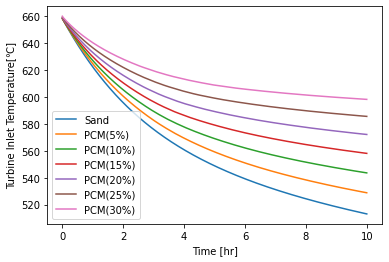

In [ ]:
plt.plot(sand_discharging.tarray/3600, sand_discharging.Tfarray[:,-1]-273.15, label='Sand')
plt.plot(pcm_discharging_pcm005.tarray/3600, pcm_discharging_pcm005.Tfarray[:,-1]-273.15, label='PCM(5%)')
plt.plot(pcm_discharging_pcm010.tarray/3600, pcm_discharging_pcm010.Tfarray[:,-1]-273.15, label='PCM(10%)')
plt.plot(pcm_discharging_pcm015.tarray/3600, pcm_discharging_pcm015.Tfarray[:,-1]-273.15, label='PCM(15%)')
plt.plot(pcm_discharging_pcm020.tarray/3600, pcm_discharging_pcm020.Tfarray[:,-1]-273.15, label='PCM(20%)')
plt.plot(pcm_discharging_pcm025.tarray/3600, pcm_discharging_pcm025.Tfarray[:,-1]-273.15, label='PCM(25%)')
plt.plot(pcm_discharging_pcm030.tarray/3600, pcm_discharging_pcm030.Tfarray[:,-1]-273.15, label='PCM(30%)')
plt.legend(loc='lower left')
plt.xlabel('Time [hr]')
plt.ylabel('Turbine Inlet Temperature[℃]')

plt.savefig('TITvstime.png')


In [ ]:
np.shape(sand_discharging.Tfarray[:,-1]-273.15)

(5498,)

# Sand 애니메이션

c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Legend does not support 'T' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Legend does not support 'l' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site

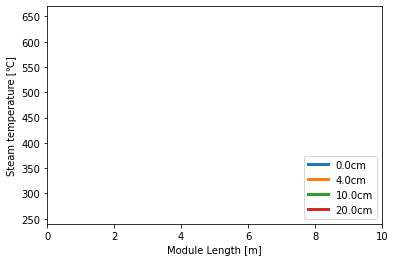

MovieWriter imagemagick unavailable; using Pillow instead.


In [ ]:
from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = plt.axes(xlim=(0, 10.0), ylim=(240,670))

line1, = ax.plot([],[],lw=3)
line2, = ax.plot([],[],lw=3)
line3, = ax.plot([],[],lw=3)
line4, = ax.plot([],[],lw=3)


title = ax.text(0.5,0.85, "", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
                transform=ax.transAxes, ha="center")
ax.legend('Tfluid','Twall')
ax.set_xlabel('Module Length [m]')
ax.set_ylabel('Steam temperature [℃]')

ax.legend(['0.0cm',str(sand_discharging.rpos[sand_discharging.Nrad_pipe-1]*100)+'cm',
           str(round(sand_discharging.rpos[int((sand_discharging.Nrad_pipe+sand_discharging.Nrad_sand)/2)],1)*100)+'cm',
           str(sand_discharging.rpos[-1]*100)+'cm'],loc='lower right')

def animate(i):
    title.set_text('time: {} hour'.format(round(sand_discharging.tarray[10*i]/3600,2)))
    x = sand_discharging.Lpos
    y1 = sand_discharging.Tfarray[10*i,:].reshape(-1)-273.15
    y2 = sand_discharging.Tarray[10*i,sand_discharging.Nrad_pipe-1,:]-273.15
    y3 = sand_discharging.Tarray[10*i,int((sand_discharging.Nrad_pipe+sand_discharging.Nrad_sand)/2),:]-273.15
    y4 = sand_discharging.Tarray[10*i,-1,:]-273.15
    line1.set_data(x,y1)
    line2.set_data(x,y2)
    line3.set_data(x,y3)
    line4.set_data(x,y4)
    return (line1,line2,line3,line4)

anim = FuncAnimation(fig=fig, func=animate, frames = int(len(sand_discharging.tarray)/10), interval = 1)
plt.show()

anim.save('Discharging_240_sand.gif',writer='imagemagick')


# PCM 애니메이션

c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Legend does not support 'T' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_path()
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_path()
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Legend does not support 'l' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifical

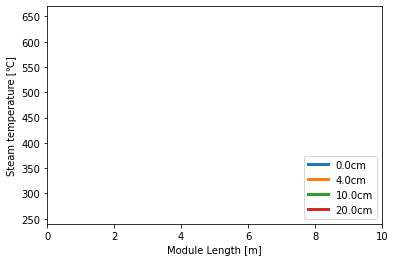

MovieWriter imagemagick unavailable; using Pillow instead.


In [ ]:


fig = plt.figure()
ax = plt.axes(xlim=(0, 10.0), ylim=(240,670))

line1, = ax.plot([],[],lw=3)
line2, = ax.plot([],[],lw=3)
line3, = ax.plot([],[],lw=3)
line4, = ax.plot([],[],lw=3)

title = ax.text(0.5,0.85, "", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
                transform=ax.transAxes, ha="center")
ax.legend('Tfluid','Twall')
ax.set_xlabel('Module Length [m]')
ax.set_ylabel('Steam temperature [℃]')
ax.legend(['0.0cm',str(sand_discharging.rpos[sand_discharging.Nrad_pipe-1]*100)+'cm',
           str(round(sand_discharging.rpos[int((sand_discharging.Nrad_pipe+sand_discharging.Nrad_sand)/2)],1)*100)+'cm',
           str(sand_discharging.rpos[-1]*100)+'cm'],loc='lower right')

def animate(i):
    title.set_text('time: {} hour'.format(round(pcm_discharging_pcm030.tarray[10*i]/3600,2)))
    x = pcm_discharging_pcm030.Lpos
    y1 = pcm_discharging_pcm030.Tfarray[10*i,:].reshape(-1)-273.15
    y2 = pcm_discharging_pcm030.Tarray[10*i,pcm_discharging_pcm030.Nrad_pipe-1,:]-273.15
    y3 = pcm_discharging_pcm030.Tarray[10*i,int((sand_discharging.Nrad_pipe+sand_discharging.Nrad_sand)/2),:]-273.15
    y4 = pcm_discharging_pcm030.Tarray[10*i,-1,:]-273.15
    line1.set_data(x,y1)
    line2.set_data(x,y2)
    line3.set_data(x,y3)
    line4.set_data(x,y4)
    return (line1,line2,line3,line4)

anim = FuncAnimation(fig=fig, func=animate, frames = int(len(pcm_discharging_pcm030.tarray)/10), interval = 1)
plt.show()

anim.save('Discharging_240_pcm.gif',writer='imagemagick')


In [ ]:
2/(1/2643.081506 + 1/2472.53442)


2554.9650689121872